In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import MiniBatchKMeans

sns.set_theme(style="darkgrid")
from multiprocessing import cpu_count

max_cores = cpu_count()
print("Max cores available: ", max_cores)


Max cores available:  8


In [2]:
tb_vulture = pd.read_csv(
    "data/Long-range adult movements of 3 vulture species (data from Spiegel et al. 2015).csv",
    parse_dates=["timestamp"],
    infer_datetime_format=True,
)
tb_vulture = tb_vulture.sort_values(by=["individual-local-identifier", "timestamp"])
tb_vulture["day"] = (
    tb_vulture["timestamp"].dt.year * 10000
    + tb_vulture["timestamp"].dt.month * 100
    + tb_vulture["timestamp"].dt.day
).astype(str)
tb_vulture["individual-local-identifier"] = tb_vulture[
    "individual-local-identifier"
].astype("category")
tb_vulture["time"] = tb_vulture["timestamp"].dt.time
tb_vulture["timestamp-l1"] = tb_vulture.groupby(["individual-local-identifier", "day"])[
    "timestamp"
].shift()
tb_vulture["timestep"] = (tb_vulture["timestamp"] - tb_vulture["timestamp-l1"]) / np.timedelta64(1, "m")  # type: ignore
tb_vulture["days_since_start"] = (tb_vulture["timestamp"] - tb_vulture.groupby("individual-local-identifier")["timestamp"].transform(min)) / pd.Timedelta("1 day")  # type: ignore
tb_vulture = tb_vulture.sort_values("timestamp")

/var/folders/c2/4vv1dtt97gl9bn1lvw8rf0k40000gn/T/ipykernel_74759/3234811408.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tb_vulture = pd.read_csv(


In [3]:
tb_day = (
    tb_vulture.groupby(["individual-local-identifier",  "day"], observed=True)
    .agg(
        start_time=("timestamp", "min"),
        end_time=("timestamp", "max"),
        num_obs=("timestamp", "count"),
    )
    .reset_index()
)
tb_day["start_hsm"] = (
    tb_day["start_time"] - tb_day["start_time"].dt.normalize()
) / pd.Timedelta("1 hour")
tb_day["end_hsm"] = (
    tb_day["end_time"] - tb_day["end_time"].dt.normalize()
) / pd.Timedelta("1 hour")
tb_day["timestamp"] = pd.to_datetime(tb_day["day"], format="%Y%m%d") + pd.Timedelta(12, unit="h")
tb_day = tb_day.sort_values("timestamp")
tb_day = pd.merge_asof(tb_day, tb_vulture[["timestamp", "individual-local-identifier", "individual-taxon-canonical-name", "location-lat", "location-long"]], on="timestamp", by="individual-local-identifier", direction="nearest")
tb_day["fulvus"] = np.where(tb_day["individual-taxon-canonical-name"] == "Gyps fulvus", 1, 0)
tb_day["torgos"] = np.where(tb_day["individual-taxon-canonical-name"] == "Torgos tracheliotus", 1, 0)
tb_day = tb_day.sort_values(["individual-local-identifier", "timestamp"])

In [4]:
tb_vulture["individual-taxon-canonical-name"].value_counts()

individual-taxon-canonical-name
Gyps fulvus            71706
Gyps africanus         53928
Torgos tracheliotus    26960
Name: count, dtype: int64

Text(0.5, 0.91, 'Vulture Flight Paths')

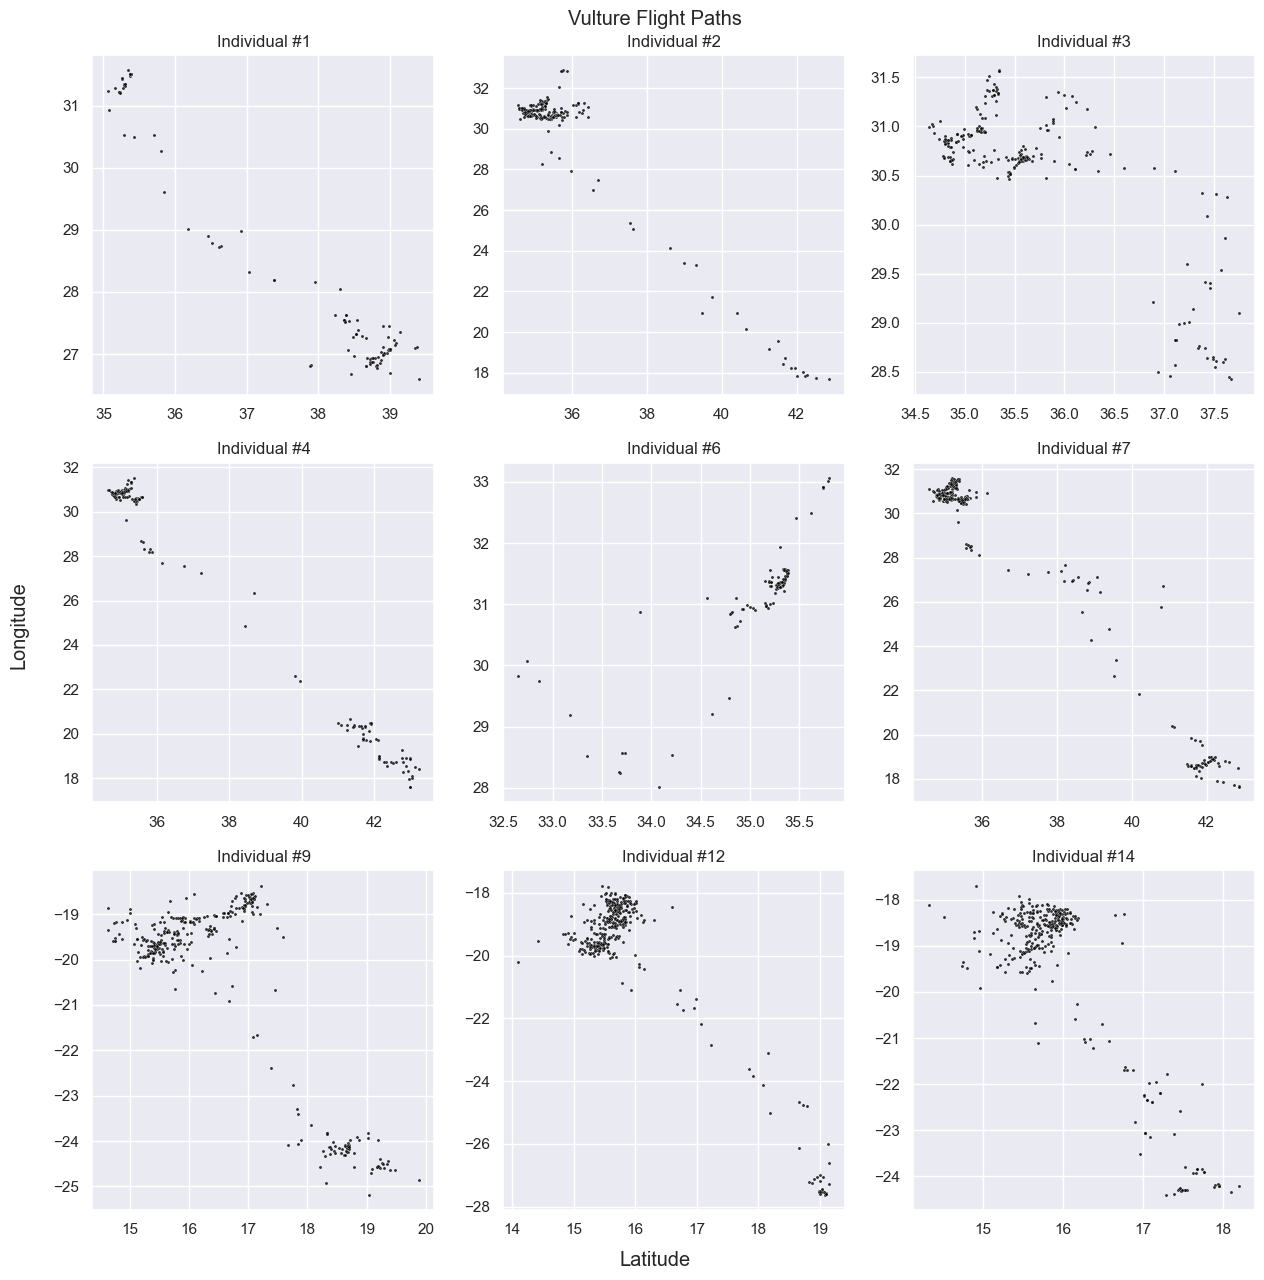

In [43]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, (name, group) in enumerate(tb_day.groupby("individual-local-identifier")):
    sns.scatterplot(
        x="location-long",
        y="location-lat",
        data=group,
        ax=ax[i // 3, i % 3],
        color="black",
        s=5,
        alpha=0.8,
    )
    ax[i // 3, i % 3].set_title(f"Individual #{name}")
    ax[i // 3, i % 3].set_xlabel("")
    ax[i // 3, i % 3].set_ylabel("")
fig.supxlabel("Latitude", y=0.07)
fig.supylabel("Longitude", x=0.07)
fig.suptitle("Vulture Flight Paths", y=0.91)


In [46]:
tb_day[tb_day["fulvus"] == 0].to_parquet("data_output/tb_day.parquet")

<Axes: xlabel='location-long', ylabel='location-lat'>

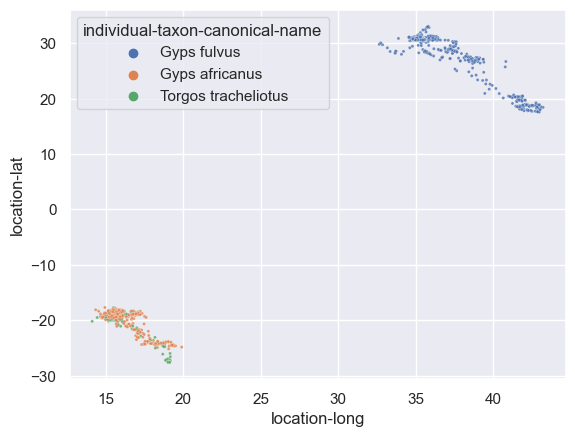

In [45]:
sns.scatterplot(
    x="location-long",
    y="location-lat",
    data=tb_day,
    hue = "individual-taxon-canonical-name",
    s=5,
    alpha=0.8,
)